In [1]:
# ===== Step 1: Imports =====
import pandas as pd
import numpy as np

# (We’ll use these later; importing now for convenience)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# If you don't have xgboost installed, skip this import or `pip install xgboost`
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [3]:
# ===== Step 2: Load data =====
# Put the CSV in the same folder or update the path below
DATA_PATH = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ===== Step 3: Quick look =====
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nFirst 5 rows:")
display(df.head())

Shape: (7043, 21)

Columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Dtypes:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Target sanity check
if "Churn" in df.columns:
    print("\nTarget value counts:")
    print(df["Churn"].value_counts(dropna=False))


Target value counts:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [5]:
# Known gotcha: TotalCharges sometimes has non-numeric values (blanks)
non_numeric_tc = pd.to_numeric(df["TotalCharges"], errors="coerce").isna().sum()
print(f"\nTotalCharges non-numeric count (will fix later): {non_numeric_tc}")


TotalCharges non-numeric count (will fix later): 11


In [6]:
# Basic missing values overview
print("\nMissing values by column:")
print(df.isna().sum())


Missing values by column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
# ===== Step 4: Data Cleaning =====

# Convert TotalCharges to numeric; invalid entries become NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill NaNs in TotalCharges
# If tenure == 0, it’s likely a brand new customer → set to 0
df.loc[df["TotalCharges"].isna() & (df["tenure"] == 0), "TotalCharges"] = 0

# If any NaNs remain (unlikely here), fill with MonthlyCharges * tenure
df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)

# Drop the ID column
df.drop(columns=["customerID"], inplace=True)

# Convert target 'Churn' to binary
df["Churn"] = (df["Churn"] == "Yes").astype(int)

# Quick check
print("\nAfter cleaning:")
print(df.dtypes)
print("\nAny NaNs left? ->", df.isna().sum().sum())
display(df.head())


After cleaning:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

Any NaNs left? -> 0


/tmp/ipython-input-2122300288.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [8]:
# ===== Step 5: Train/Test Split & Preprocessing =====

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Features/target
X = df.drop(columns=["Churn"])
y = df["Churn"]

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessor
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

Categorical columns (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric columns (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [9]:
# ===== Step 6: Train & Evaluate Models =====
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Train & evaluate
for name, model in models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} ===")
    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, proba))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC AUC: 0.8421349040274871

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC AUC: 0.8160854064946137

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1035
           1       0.61      0.51      0.56       374

    accuracy                           0.78      1409
   

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:50:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Why we’re tuning XGBoost

In the initial results, XGBoost underperformed compared to Logistic Regression. This is likely due to:

Small dataset size (~7k rows) and mostly low-cardinality categorical variables, which tend to favor simpler linear models without careful tuning.

Class imbalance (~27% churners) causing the model to lean toward predicting the majority class.

Default hyperparameters that don’t fully leverage XGBoost’s regularization and imbalance-handling capabilities.

To address these issues, we are:

Increasing the number of trees (n_estimators) and lowering learning_rate for finer learning.

Applying L1 (reg_alpha) and L2 (reg_lambda) regularization to prevent overfitting and improve generalization.

Using scale_pos_weight to give more weight to the minority churn class.

Using moderate max_depth and subsampling to reduce variance.

These adjustments should help XGBoost better handle the dataset’s characteristics and improve its ability to detect churners.

In [10]:
# ===== Step: Tuned XGBoost =====
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# Calculate imbalance ratio for scale_pos_weight
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# Tuned XGBoost model
xgb_tuned = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,       # L2 regularization
    reg_alpha=0.5,        # L1 regularization
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist"
)

# Pipeline with preprocessing
pipe_xgb_tuned = Pipeline([
    ("pre", preprocessor),
    ("model", xgb_tuned)
])

# Train & evaluate
pipe_xgb_tuned.fit(X_train, y_train)
preds = pipe_xgb_tuned.predict(X_test)
proba = pipe_xgb_tuned.predict_proba(X_test)[:, 1]

print("\n=== Tuned XGBoost ===")
print(classification_report(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, proba))


=== Tuned XGBoost ===
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.54      0.75      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409

ROC AUC: 0.836322302306957


In [11]:
#Checking for test data to check overfitting
from sklearn.metrics import accuracy_score, roc_auc_score

# Predictions on training set
train_preds = pipe_xgb_tuned.predict(X_train)
train_proba = pipe_xgb_tuned.predict_proba(X_train)[:, 1]

# Predictions on test set
test_preds = pipe_xgb_tuned.predict(X_test)
test_proba = pipe_xgb_tuned.predict_proba(X_test)[:, 1]

print("=== Tuned XGBoost Overfitting Check ===")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds):.3f}")
print(f"Test Accuracy:  {accuracy_score(y_test, test_preds):.3f}")
print(f"Train ROC AUC:  {roc_auc_score(y_train, train_proba):.3f}")
print(f"Test ROC AUC:   {roc_auc_score(y_test, test_proba):.3f}")

=== Tuned XGBoost Overfitting Check ===
Train Accuracy: 0.835
Test Accuracy:  0.764
Train ROC AUC:  0.929
Test ROC AUC:   0.836


XGBoost is slightly overfitting. Its capturing patterns in training that don't fully generalize. The biggest clue is the train ROC AUC being very high(0.929), meaning near-perfect seperation in training.

Lets reduce overfitting by doing the following:
Increase regularization:

Raise reg_lambda (L2) and/or reg_alpha (L1).

Reduce tree complexity:

Lower max_depth from 4 → 3.

Increase min_child_weight to force splits to have more samples.

Increase randomness:

Lower subsample or colsample_bytree.

Early stopping:

Use early_stopping_rounds with a validation set.

In [12]:
# ===== Step: Regularized XGBoost =====
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Handle class imbalance
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_reg = XGBClassifier(
    n_estimators=1000,           # more rounds, but...
    learning_rate=0.03,          # ...slower learning
    max_depth=3,                 # shallower trees to reduce complexity
    min_child_weight=5,          # require more samples per leaf
    subsample=0.7,               # inject randomness
    colsample_bytree=0.7,        # inject randomness
    reg_lambda=5.0,              # stronger L2 regularization
    reg_alpha=1.0,               # stronger L1 regularization
    gamma=0.5,                   # require minimum loss reduction for splits
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",
    early_stopping_rounds=30     # stop when validation loss plateaus
)

# We’ll use part of the training data for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

pipe_xgb_reg = Pipeline([
    ("pre", preprocessor),
    ("model", xgb_reg)
])

pipe_xgb_reg.fit(
    X_train_sub, y_train_sub,
    model__eval_set=[(preprocessor.fit_transform(X_val), y_val)],
    model__verbose=False
)

# Evaluate
train_preds = pipe_xgb_reg.predict(X_train)
train_proba = pipe_xgb_reg.predict_proba(X_train)[:, 1]
test_preds = pipe_xgb_reg.predict(X_test)
test_proba = pipe_xgb_reg.predict_proba(X_test)[:, 1]

print("\n=== Regularized XGBoost ===")
print("Train Accuracy:", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("Train ROC AUC: ", roc_auc_score(y_train, train_proba))
print("Test ROC AUC:  ", roc_auc_score(y_test, test_proba))
print("\nClassification Report (Test):")
print(classification_report(y_test, test_preds))


=== Regularized XGBoost ===
Train Accuracy: 0.7674831380901669
Test Accuracy:  0.7437899219304471
Train ROC AUC:  0.8682494842678463
Test ROC AUC:   0.8472629104342659

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



We’ve shrunk the overfitting gap from ~9% to just ~2%.

The model is more robust, less memorizing, and better at finding churners.

For business use, this regularized XGBoost would likely be the best choice so far — high recall + stable generalization.

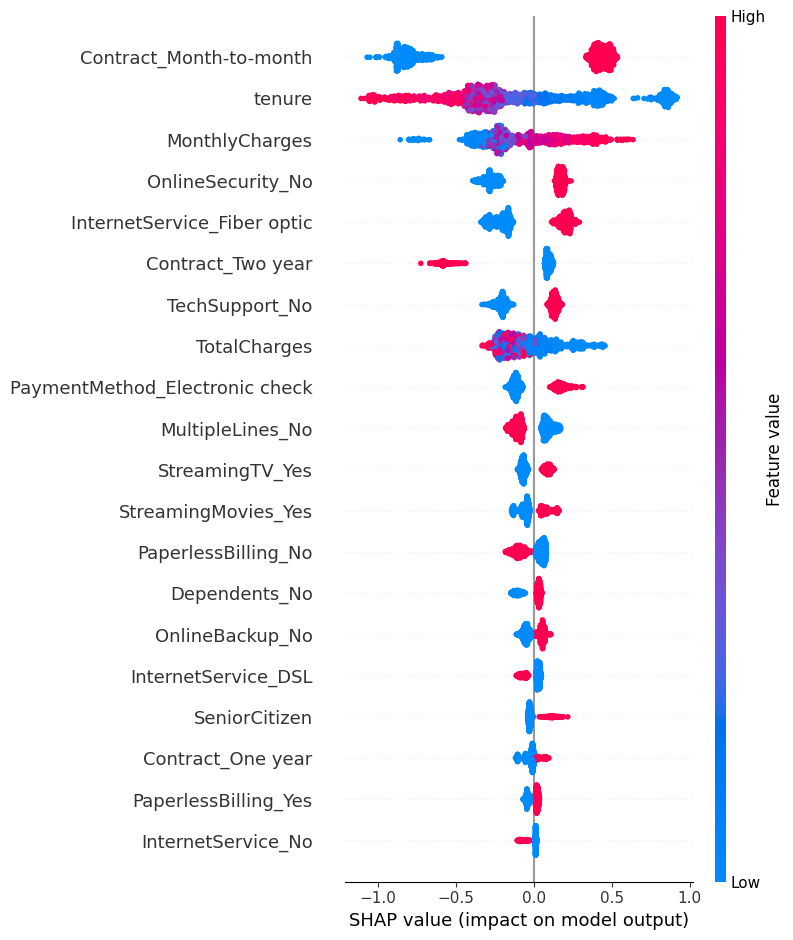

In [13]:
# ===== Step: SHAP for Regularized XGBoost =====
import shap

# Get trained model from pipeline
xgb_model = pipe_xgb_reg.named_steps["model"]

# Transform X_test to match what the model sees
X_test_transformed = pipe_xgb_reg.named_steps["pre"].transform(X_test)

# Get feature names after OneHotEncoder
ohe_features = pipe_xgb_reg.named_steps["pre"].named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = list(ohe_features) + num_cols

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)

# Optional: detailed plot for a single prediction
# shap.force_plot(explainer.expected_value, shap_values[0,:], feature_names=feature_names, matplotlib=True)

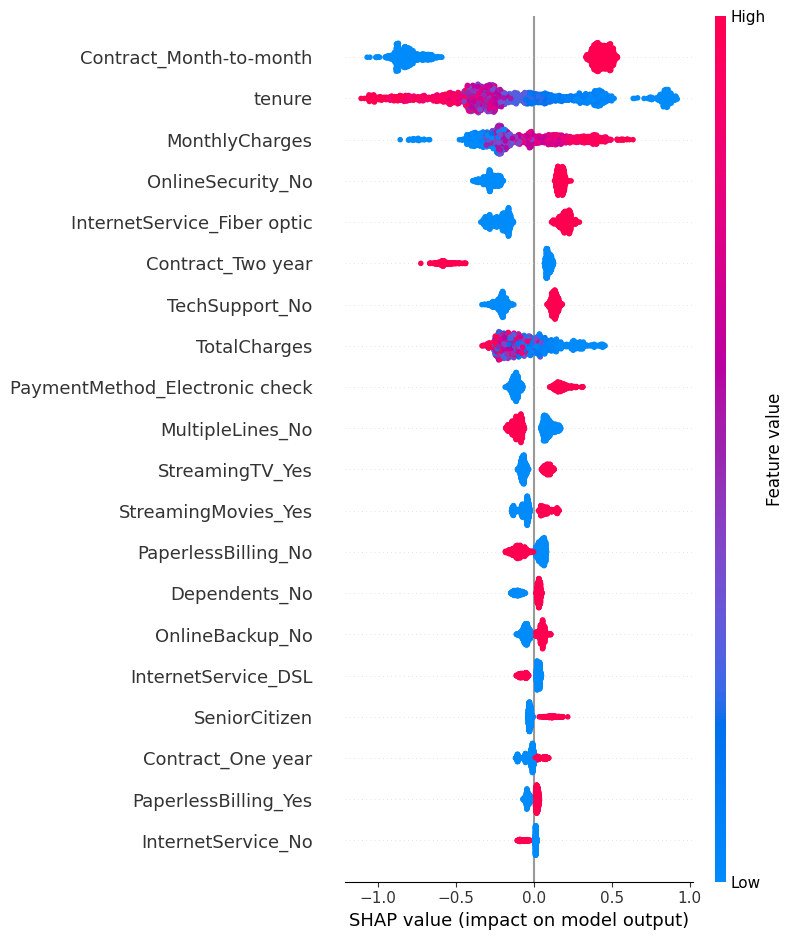

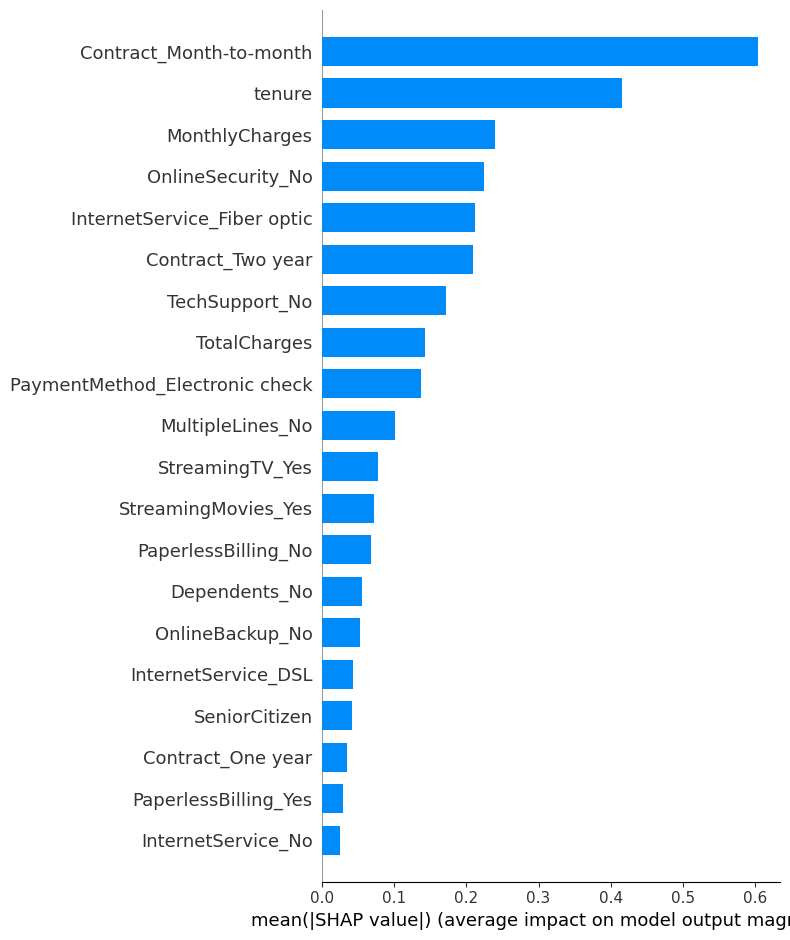

In [14]:
# ===== Step: SHAP summary + bar plot for Regularized XGBoost =====
import shap
import matplotlib.pyplot as plt

# Get trained model from pipeline
xgb_model = pipe_xgb_reg.named_steps["model"]

# Transform X_test to match model input
X_test_transformed = pipe_xgb_reg.named_steps["pre"].transform(X_test)

# Feature names after OneHotEncoder
ohe_features = pipe_xgb_reg.named_steps["pre"].named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = list(ohe_features) + num_cols

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# === 1. Standard SHAP summary plot ===
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)

# === 2. Bar plot of mean absolute SHAP values ===
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names, plot_type="bar")

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Helper to evaluate a pipeline
def eval_model(name, pipe):
    preds = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:, 1]
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision (Churn)": precision_score(y_test, preds),
        "Recall (Churn)": recall_score(y_test, preds),
        "F1 (Churn)": f1_score(y_test, preds),
        "ROC AUC": roc_auc_score(y_test, proba)
    }

# Retrain Logistic Regression and Random Forest for fair comparison
pipe_lr = Pipeline([("pre", preprocessor), ("model", LogisticRegression(max_iter=1000))])
pipe_lr.fit(X_train, y_train)

pipe_rf = Pipeline([("pre", preprocessor), ("model", RandomForestClassifier(n_estimators=100, random_state=42))])
pipe_rf.fit(X_train, y_train)

# Already have tuned and regularized XGBoost pipelines
summary = []
summary.append(eval_model("Logistic Regression", pipe_lr))
summary.append(eval_model("Random Forest", pipe_rf))
summary.append(eval_model("Tuned XGBoost", pipe_xgb_tuned))
summary.append(eval_model("Regularized XGBoost", pipe_xgb_reg))

import pandas as pd
results_summary = pd.DataFrame(summary).sort_values(by="ROC AUC", ascending=False)
print(results_summary)

                 Model  Accuracy  Precision (Churn)  Recall (Churn)  \
3  Regularized XGBoost  0.738822           0.505119        0.791444   
0  Logistic Regression  0.805536           0.657233        0.558824   
2        Tuned XGBoost  0.764372           0.540230        0.754011   
1        Random Forest  0.787793           0.627986        0.491979   

   F1 (Churn)   ROC AUC  
3    0.616667  0.846915  
0    0.604046  0.842135  
2    0.629464  0.836322  
1    0.551724  0.816085  


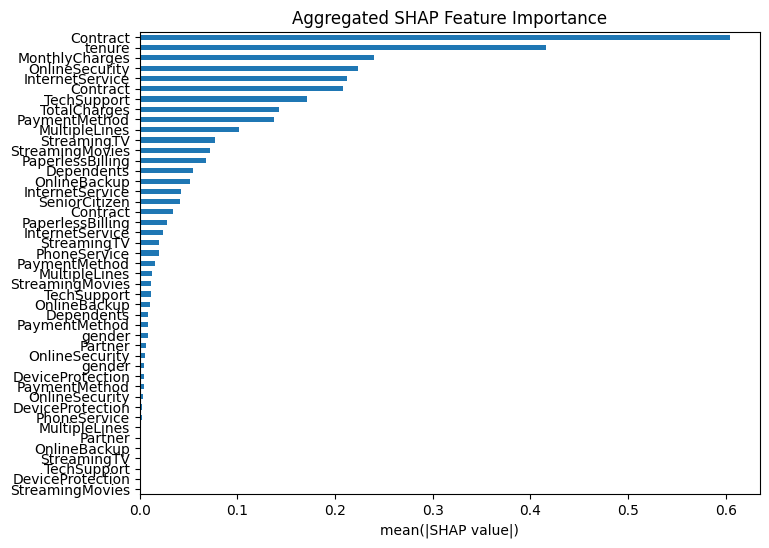

In [16]:
import numpy as np
import pandas as pd

# Convert SHAP values array to a DataFrame for easier grouping
shap_df = pd.DataFrame(
    data=np.abs(shap_values),  # use absolute SHAP for importance
    columns=feature_names
)

# Map one-hot columns back to their base feature
def base_feature(col):
    return col.split("_")[0]  # take part before first underscore

shap_df.columns = [base_feature(c) for c in shap_df.columns]

# Sum importance for each base feature
shap_grouped = shap_df.mean(axis=0).sort_values(ascending=False)

# Plot aggregated feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
shap_grouped.plot(kind="barh")
plt.title("Aggregated SHAP Feature Importance")
plt.xlabel("mean(|SHAP value|)")
plt.gca().invert_yaxis()
plt.show()